In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial

import joblib as jbl
import polars as pl

from mts_ml_cup import feature_engineering as fe
from mts_ml_cup import urls as u

In [3]:
%%time
sessions = pl.read_parquet("../data/processed/sessions.pq")

CPU times: user 35.4 s, sys: 11 s, total: 46.4 s
Wall time: 22 s


In [32]:
%%time
(
    fe.device.main(sessions)
    .write_parquet("../data/feat/device.pq")
)

CPU times: user 57 s, sys: 13.2 s, total: 1min 10s
Wall time: 15.3 s


In [57]:
%%time
(
    fe.geo.main(
        sessions=sessions, 
        rosstat_stats=pl.read_csv("../data/processed/rosstat-mts.csv"), 
        regions_mapping=jbl.load("../data/mappings/regions.jbl"),
    )
    .write_parquet("../data/feat/geo.pq")
)

CPU times: user 47.3 s, sys: 12.7 s, total: 1min
Wall time: 8.54 s


In [6]:
%%time
(
    fe.history.main(
        sessions=sessions,
        url_cleaner=partial(
            u.clean_url,
            preprocessors=[
                u.decode_from_punycode,
                u.lower,
                u.replace_hyphens_with_points,
            ],
        )
    )
    .write_parquet("../data/feat/history.pq")
)

CPU times: user 1h 46min 18s, sys: 7min 17s, total: 1h 53min 36s
Wall time: 11min 26s


In [ ]:
pl.read_parquet("../data/feat/history.pq")

# агрегаты по пользователю

## паттерны серфинга
* кол-во запросов (+ отношения в разрезе по временам суток + среднее за 1 день/часть дня)
* кол-во уникальных урлов (+ отношения в разрезе по временам суток + среднее за 1 день/часть дня)
* средняя длина урла в символах (+ отношения в разрезе по временам суток + среднее за 1 день/часть дня)
* средняя длина урла в доменных именах (+ отношения в разрезе по временам суток + среднее за 1 день/часть дня)
* кол-во строк/дней/частей дней

* подумать про совпадения множеств

## гео-инфа
* топ-регион и топ-город
* кол-во уникальных регионов и городов

# geo

1. топ-регион/топ-город для каждого пользователя – считаем, что это его родные регион и город

2. расчет статистик по **топ-региону/топ-городу**
    * кол-во пользователей в топ-регионе/топ-городе (+отношение к общему)
    * кол-во запросов в топ-регионе/топ-городе (+отношение к общему)
    * кол-во уникальных урлов в топ-регионе/топ-городе (+отношение к общему)
    
    * средняя длина урла в символах в топ-регионе/топ-городе (+отношение к среднему)
    * среднее кол-во доменных имен в топ-регионе/топ-городе (+отношение к среднему)
    
    * среднее кол-во запросов в топ-регионе/топ-городе на 1 пользователя (+отношение к среднему)
    * среднее кол-во уникальных урлов в топ-регионе/топ-городе на 1 пользователя (+отношение к среднему)
    * среднее кол-во запросов в топ-регионе/топ-городе на 1 пользователя во время суток (+отношение к общему)
    * среднее кол-во уникальных урлов в топ-регионе/топ-городе на 1 пользователя во время суток (+отношение к общему)
    
    * кол-во уникальных брендов/моделей в топ-регионе/топ-городе (+отношение к общему)
    * средняя цена устройства в топ-регионе/топ-городе (+отношение к общему)
    * наиболее популярное время суток в регионе
    

3. внешние данные с росстата по региону
    * кол-во мужчин и женщин (+отношение к общему)
    * кол-во жителей каждого бакета возраста (+отношение к общему)
    * кол-во городских/сельских жителей (+отношение к общему)
    * доля мужчин/женщин (+отношение к среднему)
    * доля жителей каждого бакета возраста (+отношение к среднему)
    * доля городских/сельских жителей (+отношение к среднему)

In [13]:
%%time
res = fe.geo.unique_regions(df)

CPU times: user 1min 11s, sys: 1min 29s, total: 2min 41s
Wall time: 32.3 s


In [24]:
res.to_pandas().to_parquet("../data/features/geo/n_regions.pq")

In [57]:
%%time
res = fe.geo.the_most_popular_region(df)

CPU times: user 56.6 s, sys: 23 s, total: 1min 19s
Wall time: 3.32 s


In [59]:
res.to_pandas().to_parquet("../data/features/geo/top_region.pq")

In [48]:
%%time
res = fe.geo.unique_cities(df)

CPU times: user 1min 15s, sys: 1min 51s, total: 3min 7s
Wall time: 11.1 s


In [50]:
res.to_pandas().to_parquet("../data/features/geo/n_cities.pq")

In [66]:
%%time
res = fe.geo.the_most_popular_city(df)

CPU times: user 2min 15s, sys: 2min 52s, total: 5min 7s
Wall time: 42.9 s


In [68]:
res.to_pandas().to_parquet("../data/features/geo/top_city.pq")

# device

In [74]:
manufacturers = df["cpe_manufacturer_name"].unique().to_list()

In [127]:
%%time
res = fe.device.device_manufacturer(df)

CPU times: user 1min 9s, sys: 44.5 s, total: 1min 54s
Wall time: 20 s


In [128]:
res.to_pandas().to_parquet("../data/features/device/manufacturer.pq")

In [129]:
%%time
res = fe.device.device_model(df)

CPU times: user 1min 39s, sys: 53.1 s, total: 2min 32s
Wall time: 29.5 s


In [130]:
res.to_pandas().to_parquet("../data/features/device/model.pq")

In [157]:
%%time
res = fe.device.device_mean_price(df)

CPU times: user 7.34 s, sys: 3.49 s, total: 10.8 s
Wall time: 776 ms


In [161]:
res.to_pandas().to_parquet("../data/features/device/mean_price.pq")

# url

In [169]:
%%time
res = fe.url.unique_urls(df)

CPU times: user 2min 2s, sys: 37.4 s, total: 2min 40s
Wall time: 17 s


In [170]:
res.to_pandas().to_parquet("../data/features/url/n_urls.pq")

In [174]:
%%time
res = fe.url.avg_url_length(df)

CPU times: user 2min 4s, sys: 26.7 s, total: 2min 30s
Wall time: 16.8 s


In [175]:
res.to_pandas().to_parquet("../data/features/url/avg_url_length.pq")

# session

In [197]:
%%time
res = fe.session.total_requests(df)
res.to_pandas().to_parquet("../data/features/session/total_requests.pq")

CPU times: user 6.52 s, sys: 3.48 s, total: 10 s
Wall time: 783 ms


## daily

In [188]:
%%time
res = fe.session.n_sessions(df, group=["date"], name="n_days")
res.to_pandas().to_parquet("../data/features/session/n_days.pq")

CPU times: user 2min 22s, sys: 8.26 s, total: 2min 31s
Wall time: 9.29 s


In [190]:
%%time
res = fe.session.avg_unique_urls_by_session(df, group=["date"], name="avg_urls_by_day")
res.to_pandas().to_parquet("../data/features/session/avg_urls_by_day.pq")

CPU times: user 4min 42s, sys: 1min 18s, total: 6min 1s
Wall time: 36.5 s


In [194]:
%%time
res = fe.session.avg_requests_by_session(df, group=["date"], name="avg_requests_by_day")
res.to_pandas().to_parquet("../data/features/session/avg_requests_by_day.pq")

CPU times: user 3min 27s, sys: 1min 39s, total: 5min 6s
Wall time: 46.7 s


In [215]:
%%time
res = fe.session.avg_day_parts_by_day(df)
res.to_pandas().to_parquet("../data/features/session/avg_day_parts_by_day.pq")

CPU times: user 3min 44s, sys: 24.3 s, total: 4min 8s
Wall time: 21.4 s


## semi-daily (date + part_of_day)

In [198]:
%%time
res = fe.session.n_sessions(df, group=["date", "part_of_day"], name="n_day_parts")
res.to_pandas().to_parquet("../data/features/session/n_day_parts.pq")

CPU times: user 2min 30s, sys: 19.3 s, total: 2min 49s
Wall time: 16.9 s


In [200]:
%%time
res = fe.session.avg_unique_urls_by_session(df, group=["date", "part_of_day"], name="avg_urls_by_day_part")
res.to_pandas().to_parquet("../data/features/session/avg_urls_by_day_part.pq")

CPU times: user 6min 38s, sys: 2min 7s, total: 8min 45s
Wall time: 1min 6s


In [203]:
%%time
res = fe.session.avg_requests_by_session(df, group=["date", "part_of_day"], name="avg_requests_by_day_part")
res.to_pandas().to_parquet("../data/features/session/avg_requests_by_day_part.pq")

CPU times: user 4min 1s, sys: 1min 37s, total: 5min 38s
Wall time: 1min 1s


## site-wise

In [205]:
%%time
res = fe.session.n_sessions(df, group=["date", "part_of_day", "url_host"], name="n_sessions")
res.to_pandas().to_parquet("../data/features/session/n_sessions.pq")

CPU times: user 6min 23s, sys: 2min 5s, total: 8min 28s
Wall time: 1min 43s


In [207]:
%%time
res = fe.session.avg_requests_by_session(df, group=["date", "part_of_day", "url_host"], name="avg_requests_by_session")
res.to_pandas().to_parquet("../data/features/session/avg_requests_by_session.pq")

CPU times: user 14min 36s, sys: 4min 21s, total: 18min 57s
Wall time: 4min 53s


# part_of_day stats

In [219]:
%%time
res = fe.session.the_most_popular_part_of_day(df)
res.to_pandas().to_parquet("../data/features/session/top_part_of_day.pq")

CPU times: user 1min 3s, sys: 6.4 s, total: 1min 10s
Wall time: 3.2 s


In [236]:
%%time
res = fe.part_of_day.days_share_by_part_of_day(df)
res.to_pandas().to_parquet("../data/features/part_of_day/days_share.pq")

CPU times: user 2min 32s, sys: 2min 32s, total: 5min 5s
Wall time: 1min 1s


In [240]:
%%time
res = fe.part_of_day.urls_share_by_part_of_day(df)
res.to_pandas().to_parquet("../data/features/part_of_day/urls_share.pq")

CPU times: user 3min 15s, sys: 2min 34s, total: 5min 49s
Wall time: 1min 3s


In [245]:
%%time
res = fe.part_of_day.requests_share_by_part_of_day(df)
res.to_pandas().to_parquet("../data/features/part_of_day/requests_share.pq")

CPU times: user 1min 4s, sys: 9.87 s, total: 1min 14s
Wall time: 4.05 s


In [249]:
urls = df["url_host"].unique()

In [251]:
urls.to_pandas().to_csv("../data/processed/urls.csv")

In [253]:
r = pd.read_parquet("../data/features/url/n_urls.pq")

<Axes: ylabel='Frequency'>

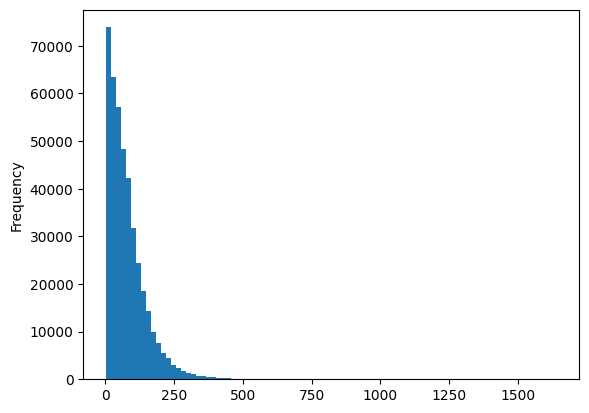

In [256]:
r["n_urls"].plot.hist(bins=90)

In [257]:
r["n_urls"].describe()

count    415317.000000
mean         77.718150
std          70.130401
min           1.000000
25%          28.000000
50%          60.000000
75%         107.000000
max        1642.000000
Name: n_urls, dtype: float64

In [263]:
r["n_urls"].quantile(0.8)

121.0

# urls

In [267]:
user_urls = (
    df
    .groupby(["user_id", "url_host"])
    .agg(pl.col("request_cnt").sum())
    .sort(["user_id", "request_cnt", "url_host"], reverse=[False, True, False])
)

In [271]:
user_total_request = user_urls.groupby("user_id").agg(pl.col("request_cnt").sum().alias("total_request_cnt"))

In [273]:
uu = user_urls.join(user_total_request, on="user_id")

In [275]:
uu = uu.with_columns((pl.col("request_cnt") / pl.col("total_request_cnt")).alias("url_request_share"))

In [279]:
user_url_usage = uu.groupby("user_id").agg(pl.col("url_request_share").cumsum())

In [302]:
%%time
user_url_usage_ = user_url_usage.with_columns(
    [
        pl.col("url_request_share")
        .apply(lambda cs: max(len(list(filter(lambda x: x < 0.5, cs))), 1))
        .alias("q50"),
        pl.col("url_request_share")
        .apply(lambda cs: max(len(list(filter(lambda x: x < 0.6, cs))), 1))
        .alias("q60"),
        pl.col("url_request_share")
        .apply(lambda cs: max(len(list(filter(lambda x: x < 0.7, cs))), 1))
        .alias("q70"),
        pl.col("url_request_share")
        .apply(lambda cs: max(len(list(filter(lambda x: x < 0.8, cs))), 1))
        .alias("q80"),
        pl.col("url_request_share")
        .apply(lambda cs: max(len(list(filter(lambda x: x < 0.9, cs))), 1))
        .alias("q90"),
        pl.col("url_request_share").apply(len).alias("q100"),
    ]
)

CPU times: user 3min 59s, sys: 5.62 s, total: 4min 4s
Wall time: 4min


In [307]:
f = (
    user_url_usage_
    .with_columns(pl.col(["q50", "q60", "q70", "q80", "q90"]) / pl.col("q100"))
)

<Axes: ylabel='Frequency'>

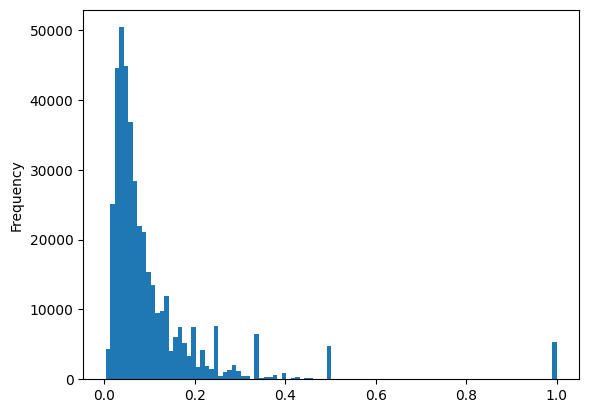

In [312]:
f["q50"].to_pandas().plot.hist(bins=100)

<Axes: ylabel='Frequency'>

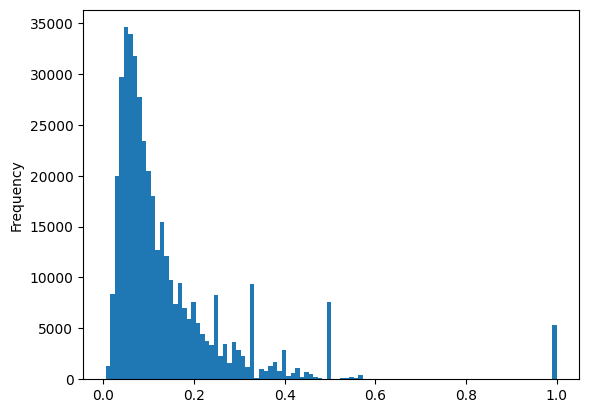

In [313]:
f["q60"].to_pandas().plot.hist(bins=100)

<Axes: ylabel='Frequency'>

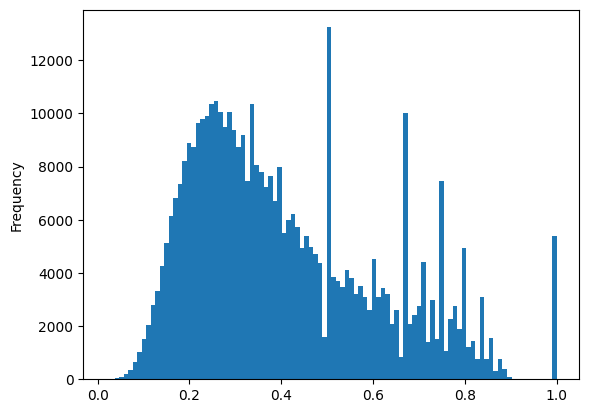

In [311]:
f["q90"].to_pandas().plot.hist(bins=100)

# regions

In [7]:
%%time
user_regions = (
    df
    .groupby(["user_id", "region_name"])
    .agg(pl.col("request_cnt").sum())
    .sort(["user_id", "request_cnt", "region_name"], reverse=[False, True, False])
)

CPU times: user 52.9 s, sys: 1min 20s, total: 2min 13s
Wall time: 5.05 s


In [10]:
user_total_request = user_regions.groupby("user_id").agg(pl.col("request_cnt").sum().alias("total_request_cnt"))

In [13]:
uu = user_regions.join(user_total_request, on="user_id")

In [15]:
uu = uu.with_columns((pl.col("request_cnt") / pl.col("total_request_cnt")).alias("region_request_share"))

In [18]:
user_region_usage = uu.groupby("user_id").agg(pl.col("region_request_share").cumsum())

In [21]:
r = user_region_usage.with_columns(pl.col("region_request_share").apply(lambda x: x[0]))

In [23]:
r["region_request_share"].describe()

statistic,value
str,f64
"""min""",0.140221
"""max""",1.0
"""null_count""",0.0
"""mean""",0.944976
"""std""",0.124158
"""count""",415317.0


# cities

In [24]:
%%time
user_cities = (
    df
    .groupby(["user_id", "region_name", "city_name"])
    .agg(pl.col("request_cnt").sum())
    .sort(["user_id", "request_cnt", "region_name", "city_name"], reverse=[False, True, False, False])
)

CPU times: user 2min 10s, sys: 3min 5s, total: 5min 16s
Wall time: 51.7 s


In [27]:
uu = user_cities.join(user_total_request, on="user_id")

In [29]:
uu = uu.with_columns((pl.col("request_cnt") / pl.col("total_request_cnt")).alias("city_request_share"))

In [31]:
user_cities_usage = uu.groupby("user_id").agg(pl.col("city_request_share").cumsum())

In [33]:
r = user_cities_usage.with_columns(pl.col("city_request_share").apply(lambda x: x[0]))

In [35]:
r["city_request_share"].describe()

statistic,value
str,f64
"""min""",0.077209
"""max""",1.0
"""null_count""",0.0
"""mean""",0.914858
"""std""",0.150585
"""count""",415317.0
